In [ ]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X = data['cleaned_text']
y = data['mental_health_issue']
y = label_encoder.transform(y)

# Split data into training and holdout sets (for blending)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_holdout_one_hot = to_categorical(y_holdout, num_classes=len(label_encoder.classes_))

# Preprocess the text for the training set
X_train_lr = lr_vectorizer.transform(X_train)
X_train_svm = svm_vectorizer.transform(X_train)
X_train_nb = nb_vectorizer.transform(X_train)
X_train_xgb = tfidf_vectorizer.transform(X_train)
X_train_lstm = lstm_tokenizer.texts_to_sequences(X_train)
X_train_lstm = pad_sequences(X_train_lstm, maxlen=100, padding='post', truncating='post')

# Train base models
lr_model.fit(X_train_lr, y_train)
svm_model.fit(X_train_svm, y_train)
nb_model.fit(X_train_nb, y_train)
xgb_model.fit(X_train_xgb, y_train)

# Recompile the LSTM model to reset the optimizer
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the LSTM model with one-hot encoded labels
lstm_model.fit(X_train_lstm, y_train_one_hot, epochs=3, batch_size=32)  # Adjust epochs and batch size as needed

# Preprocess the text for the holdout set
X_holdout_lr = lr_vectorizer.transform(X_holdout)
X_holdout_svm = svm_vectorizer.transform(X_holdout)
X_holdout_nb = nb_vectorizer.transform(X_holdout)
X_holdout_xgb = tfidf_vectorizer.transform(X_holdout)
X_holdout_lstm = lstm_tokenizer.texts_to_sequences(X_holdout)
X_holdout_lstm = pad_sequences(X_holdout_lstm, maxlen=100, padding='post', truncating='post')

# Get predictions from base models on the holdout set
lr_predictions_proba = lr_model.predict_proba(X_holdout_lr)
svm_predictions_proba = svm_model.predict_proba(X_holdout_svm)
nb_predictions_proba = nb_model.predict_proba(X_holdout_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_holdout_xgb)
lstm_predictions_proba = lstm_model.predict(X_holdout_lstm)

# Stack the predictions to create the feature matrix for the meta-learner (blending)
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_split=20,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

# Fit the meta-learner using the predictions from the base models (holdout set)
meta_learner_rf.fit(stacked_features, y_holdout)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf_blending.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner on the holdout set
final_predictions_rf = meta_learner_rf.predict(stacked_features)

# Evaluate the Random Forest blending model
accuracy_rf = accuracy_score(y_holdout, final_predictions_rf)
report_rf = classification_report(y_holdout, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy (Blending): {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_holdout, final_predictions_rf))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:42:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Epoch 1/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 73s 152ms/step - accuracy: 0.8681 - loss: 0.3894
Epoch 2/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - accuracy: 0.9087 - loss: 0.2800
Epoch 3/3
465/465 ━━━━━━━━━━━━━━━━━━━━ 70s 150ms/step - accuracy: 0.9284 - loss: 0.2256
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
Random Forest Meta-Learner Accuracy (Blending): 97.82%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.97      0.97      0.97       379
     bipolar       0.96      0.91      0.94       384
  depression       0.93      0.96      0.94       373
      normal       0.99      1.00      0.99      2183
        ptsd       0.97      0.97      0.97       394

    accuracy                           0.98      3713
   macro avg       0.96      0.96      0.96      3713
weighted avg       0.98      0.98      0.98      3713

Confusion Matrix (Random Forest):
 [[ 366    2    6    1    4]
 [   2  351   15   14    2]
 [   6    3  357   

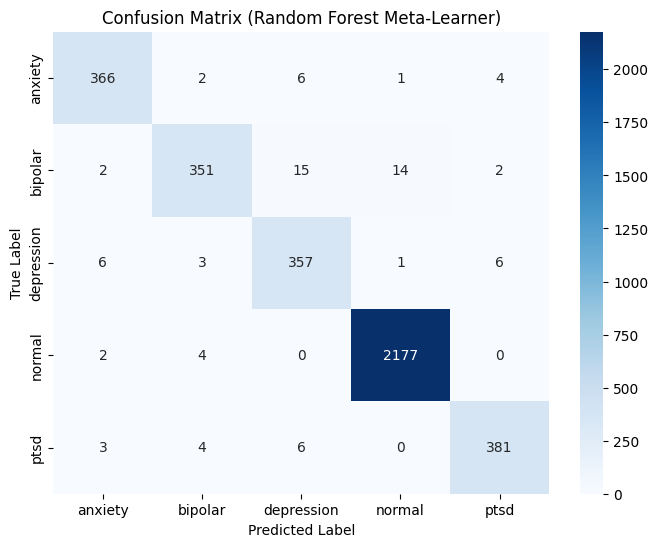

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_holdout, final_predictions_rf)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Random Forest Meta-Learner)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


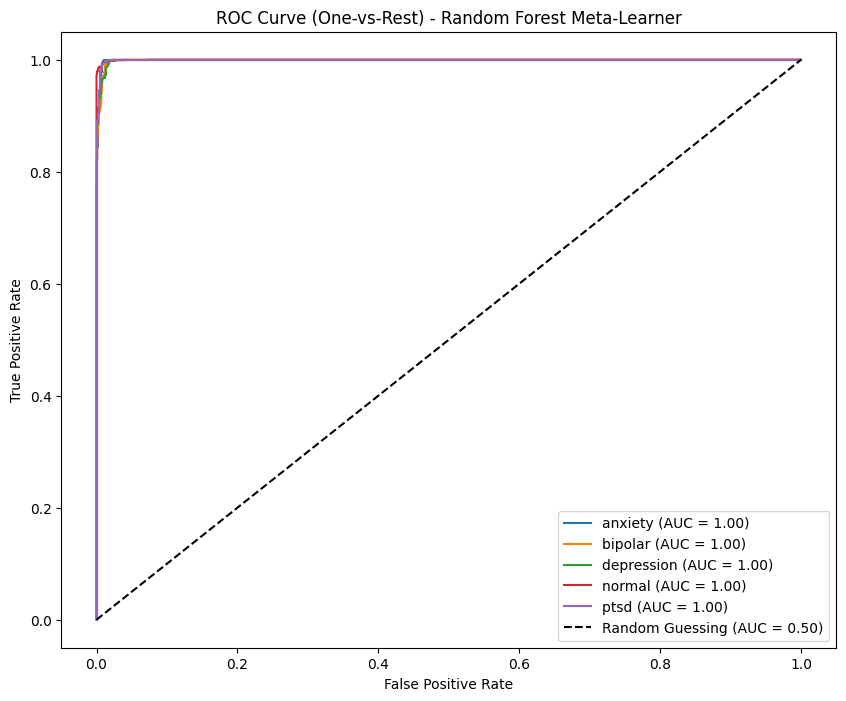

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC AUC (One-vs-Rest approach)
y_bin = label_binarize(y_holdout, classes=np.arange(len(label_encoder.classes_)))

# Get the predicted probabilities for each class
y_probs_rf = meta_learner_rf.predict_proba(stacked_features)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot diagonal line (no skill)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')

plt.title('ROC Curve (One-vs-Rest) - Random Forest Meta-Learner')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## final after crosss validation and train test split

In [1]:
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression  # Used as the meta-learner for blending
from sklearn.model_selection import cross_val_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X = data['cleaned_text']
y = data['mental_health_issue']
y = label_encoder.transform(y)

# Preprocess the text
X_lr = lr_vectorizer.transform(X)
X_svm = svm_vectorizer.transform(X)
X_nb = nb_vectorizer.transform(X)
X_xgb = tfidf_vectorizer.transform(X)
X_lstm = lstm_tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_lr)
svm_predictions_proba = svm_model.predict_proba(X_svm)
nb_predictions_proba = nb_model.predict_proba(X_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_xgb)
lstm_predictions_proba = lstm_model.predict(X_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Split data into training and test sets for blending
X_train, X_test, y_train, y_test = train_test_split(
    stacked_features, y, test_size=0.2, random_state=42, stratify=y
)

# Further split training data into meta-learner training and validation sets
X_meta_train, X_meta_val, y_meta_train, y_meta_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# Train a meta-learner using Logistic Regression
meta_learner_blending = LogisticRegression(max_iter=1000, random_state=42)
meta_learner_blending.fit(X_meta_train, y_meta_train)

# Use the meta-learner to predict on validation set and test set
val_predictions_blending = meta_learner_blending.predict(X_meta_val)
test_predictions_blending = meta_learner_blending.predict(X_test)

# Evaluate the blending meta-learner on validation and test sets
val_accuracy_blending = accuracy_score(y_meta_val, val_predictions_blending)
test_accuracy_blending = accuracy_score(y_test, test_predictions_blending)

val_report_blending = classification_report(y_meta_val, val_predictions_blending, target_names=label_encoder.classes_)
test_report_blending = classification_report(y_test, test_predictions_blending, target_names=label_encoder.classes_)

print(f"Blending Meta-Learner Validation Accuracy: {val_accuracy_blending * 100:.2f}%")
print("Classification Report (Validation Set):\n", val_report_blending)
print(f"Blending Meta-Learner Test Accuracy: {test_accuracy_blending * 100:.2f}%")
print("Classification Report (Test Set):\n", test_report_blending)
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, test_predictions_blending))

# Save the trained blending meta-learner
with open('meta_learner_blending.pkl', 'wb') as file:
    pickle.dump(meta_learner_blending, file)

# Perform cross-validation to calculate mean and standard deviation of validation accuracies
cross_val_accuracies = cross_val_score(
    meta_learner_blending, X_train, y_train, cv=5, scoring='accuracy'
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")


581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 78ms/step
Blending Meta-Learner Validation Accuracy: 97.15%
Classification Report (Validation Set):
               precision    recall  f1-score   support

     anxiety       0.96      0.95      0.95       400
     bipolar       0.94      0.90      0.92       388
  depression       0.95      0.95      0.95       392
      normal       0.98      1.00      0.99      2136
        ptsd       0.98      0.95      0.97       397

    accuracy                           0.97      3713
   macro avg       0.96      0.95      0.96      3713
weighted avg       0.97      0.97      0.97      3713

Blending Meta-Learner Test Accuracy: 97.17%
Classification Report (Test Set):
               precision    recall  f1-score   support

     anxiety       0.96      0.95      0.96       400
     bipolar       0.94      0.89      0.92       388
  depression       0.96      0.95      0.95       392
      normal       0.98      0.99      0.99      2136
        ptsd       0.97    

Blending Meta-Learner Test Accuracy: 97.17%
Classification Report (Test Set):
               precision    recall  f1-score   support

     anxiety       0.96      0.95      0.96       400
     bipolar       0.94      0.89      0.92       388
  depression       0.96      0.95      0.95       392
      normal       0.98      0.99      0.99      2136
        ptsd       0.97      0.97      0.97       397

    accuracy                           0.97      3713
   macro avg       0.96      0.95      0.96      3713
weighted avg       0.97      0.97      0.97      3713



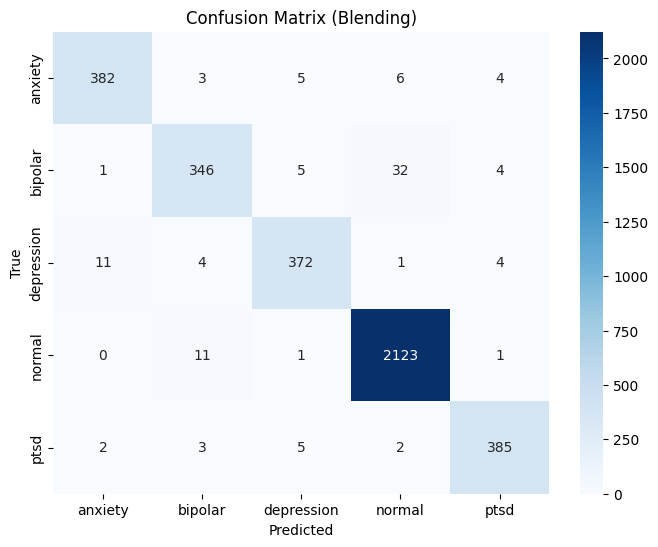

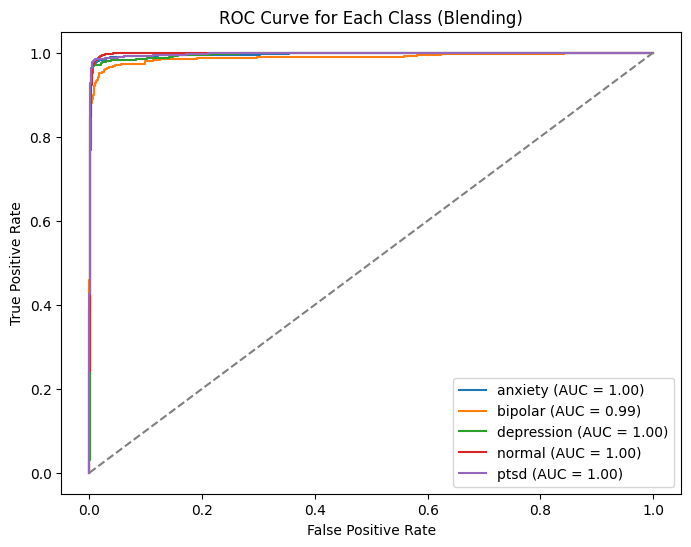

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Evaluate the Blending Meta-Learner
test_accuracy_blending = accuracy_score(y_test, test_predictions_blending)
report_blending = classification_report(y_test, test_predictions_blending, target_names=label_encoder.classes_)

# Print the test accuracy and classification report
print(f"Blending Meta-Learner Test Accuracy: {test_accuracy_blending * 100:.2f}%")
print("Classification Report (Test Set):\n", report_blending)

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions_blending)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Blending)')
plt.show()

# ROC AUC Curve
# Calculate the probability scores for the test set
y_pred_proba_blending = meta_learner_blending.predict_proba(X_test)

# Create ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba_blending[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class (Blending)')
plt.legend(loc='lower right')
plt.show()
